## Import Libraries and Dataset

### Libraries

Tensorflow and Keras will be used in this image classification problem.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load Dataset

This dataset consists two different types of images

- PNG images (transparent and clear background) that were augmented with Keras `ImageDataGenerator()`
- Photos taken with noisy background 
    - This adds noise to the dataset and simulates the actual test environment where users will take photos of these image cards with their phones

In [3]:
PATH = 'TfModels_52_fine'
# os.chdir(PATH)

In [4]:
data = []
for root, dirs, files in os.walk(PATH, topdown=True):
    for name in files:
        if '.jpg' not in name:
            continue
        filename = os.path.abspath(os.path.join(root, name))
        class_name = os.path.basename(root)
        data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])
df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(26129, 3)


,filename,class_name,class
0,c:\Users\weich\Downloads\SMU2020\AIAPP\TfModel...,48b Symbol Guide,48
1,c:\Users\weich\Downloads\SMU2020\AIAPP\TfModel...,50a Score Card,51
2,c:\Users\weich\Downloads\SMU2020\AIAPP\TfModel...,37 New Technology,36
3,c:\Users\weich\Downloads\SMU2020\AIAPP\TfModel...,17 Pay Raise,16
4,c:\Users\weich\Downloads\SMU2020\AIAPP\TfModel...,49b Fun Facts,50


Randomly sample 300 images per class to try out different architectures.

In [5]:
# df = df.groupby('class').apply(lambda x: x.sample(n=400)).sample(frac=1).reset_index(drop = True)
df = df.loc[df['class'] < 5]
df = df.groupby('class').apply(lambda x: x.sample(n=440)).sample(frac=1).reset_index(drop = True)
print(df.shape)

(2200, 3)


In [6]:
train_set_percentage = .8
df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

## Build Data Pipeline

In [9]:
def image_augmentation(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Image augmentation 
    image = tf.image.random_flip_left_right(image, seed=None)
    image = tf.image.random_flip_up_down(image, seed=None)

    # Contrast and Brightness
    if tf.random.uniform(()) > 0.4:
        image = tf.image.random_contrast(image, 0.1, 0.9, seed=None)
    if tf.random.uniform(()) > 0.4:
        image = tf.image.random_brightness(image, max_delta=0.05, seed=None)
        image = tf.image.random_hue(image, max_delta=0.05, seed=None)

    print(image.shape)
    image_resized = image
    label = tf.one_hot(label, n_classes)    
    return image_resized, label

In [10]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string,channels=3)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    label = tf.one_hot(label, n_classes)
    return image_resized, label

IMG_SIZE = 224 # 229 for InceptionV3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
n_classes = 5
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset= train_dataset.map(image_augmentation) 
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat(50) #100
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder = True)

valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
valid_dataset = valid_dataset.batch(BATCH_SIZE)

(224, 224, 3)


### Visualize Dataset

In [11]:
image_batch, label_batch = next(iter(train_dataset))

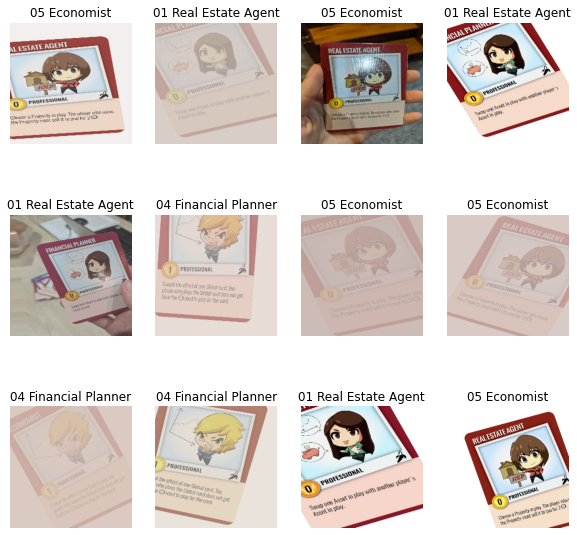

In [12]:
class_names = df['class_name'].unique()

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  index = tf.argmax(label, axis=0).numpy()
  plt.title(class_names[index])
  plt.axis("off")

## Train Model

Transfer learning is used here as we have a small dataset size. We load the NASNetMobile model from Keras Applications.

In [11]:
learning_rate = 0.0001
epochs = 30

In [11]:
base_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet', input_shape=IMG_SHAPE) 

We use the `get_layer()` function to use part of the NASNetMobile architecture rather than the whole architecture. The data visualization above showed that our dataset use less complex than the Imagenet images which were used to train the NASNetMobile architecture. This is similar to how the lower levels of the architecture captures more simple representations of the images, such as curves. Therefore, we will keep these simple representations.

In [ ]:
x = base_model.get_layer('activation_93').output
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(n_classes, activation="softmax", name="3_")(out)
model = Model(base_model.input, out)
# model.summary()

In [16]:
for layer in base_model.layers:
    layer.trainable = False

We need to ensure that the base model layers are frozen when we train the classification head. This is to avoid large gradient updates that may result in the model forgetting what it has learnt. Only after we have trained the classification head will we fine-tune the model and unfreeze the base model layers.

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = learning_rate),
              metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss',
                min_delta = 0,
                patience = 3,
                verbose = 0, mode = 'auto')

mc = ModelCheckpoint('models/nasnetS.h5',
                     monitor = 'val_accuracy', 
                     mode = 'max', 
                     verbose = 1, 
                     save_best_only = True)
model.summary()

v_2_reduction_left1_
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 14, 14, 88)   352         separable_conv_2_reduction_right1
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 33, 33, 88)   0           activation_75[0][0]              
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 28, 28, 88)   0           adjust_bn_reduce_4[0][0]         
__________________________________________________________________________________________________
reduction_add_1_reduce_4 (Add)  (None, 14, 14, 88)   0           separable_conv_2_bn_reduction_lef
                                                                 separable_conv_2_bn_reduction_rig
________________________________________________________________________________________

In [14]:
history = model.fit(train_dataset,
          epochs = epochs,
          verbose = 1,
          callbacks = [es, mc],
          validation_data = valid_dataset)

Train for 687 steps, validate for 3 steps
Epoch 1/30
686/687 [============================>.] - ETA: 1s - loss: 0.2607 - accuracy: 0.9462
Epoch 00001: val_accuracy improved from -inf to 0.25284, saving model to models/nasnetS.h5
687/687 [==============================] - 805s 1s/step - loss: 0.2603 - accuracy: 0.9463 - val_loss: 20.4524 - val_accuracy: 0.2528
Epoch 2/30
686/687 [============================>.] - ETA: 1s - loss: 0.0014 - accuracy: 0.9995
Epoch 00002: val_accuracy improved from 0.25284 to 0.44034, saving model to models/nasnetS.h5
687/687 [==============================] - 807s 1s/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 9.1147 - val_accuracy: 0.4403
Epoch 3/30
686/687 [============================>.] - ETA: 1s - loss: 7.6528e-04 - accuracy: 0.9998
Epoch 00003: val_accuracy improved from 0.44034 to 0.59375, saving model to models/nasnetS.h5
687/687 [==============================] - 801s 1s/step - loss: 7.6426e-04 - accuracy: 0.9998 - val_loss: 2.8571 - val_acc

InternalError: GPU sync failed

### Dealing with overfitting

In instances of overfitting (training accuracy >> validation accuracy), I reduced the model architecture, such as using a lower level pooling layer from the NASNetMobile architecture, and reducing the model parameters of the classification head.

## Fine-tune Model

In [12]:
model = tf.keras.models.load_model('models/nasnetS.h5')

In [16]:
i = 0
for idx, layer in enumerate(model.layers):
    if layer.name == 'normal_concat_3':
        i += idx + 1

for layer in model.layers[:i]:
    layer.trainable = False
for layer in model.layers[i:]:
    layer.trainable = True
# for layer in model.layers:
#     print(layer.name, layer.trainable)

In [17]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = learning_rate),
              metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss',
                min_delta = 0,
                patience = 3,
                verbose = 0, mode = 'auto')

mc = ModelCheckpoint('models/nasnetS_finetune.h5',
                     monitor = 'val_accuracy', 
                     mode = 'max', 
                     verbose = 1, 
                     save_best_only = True)
model.summary()

v_2_reduction_left1_
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 14, 14, 88)   352         separable_conv_2_reduction_right1
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 33, 33, 88)   0           activation_75[0][0]              
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 28, 28, 88)   0           adjust_bn_reduce_4[0][0]         
__________________________________________________________________________________________________
reduction_add_1_reduce_4 (Add)  (None, 14, 14, 88)   0           separable_conv_2_bn_reduction_lef
                                                                 separable_conv_2_bn_reduction_rig
________________________________________________________________________________________

In [18]:
fine_tune_epochs = 10
history_fine = model.fit(train_dataset,
          epochs = fine_tune_epochs,
          verbose = 1,
          callbacks = [es, mc],
          validation_data = valid_dataset)

Train for 687 steps, validate for 3 steps
Epoch 1/10
686/687 [============================>.] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993
Epoch 00001: val_accuracy improved from -inf to 0.78977, saving model to models/nasnetS_finetune.h5
687/687 [==============================] - 859s 1s/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 2.4652 - val_accuracy: 0.7898
Epoch 2/10
686/687 [============================>.] - ETA: 1s - loss: 0.0043 - accuracy: 0.9992
Epoch 00002: val_accuracy improved from 0.78977 to 0.99148, saving model to models/nasnetS_finetune.h5
687/687 [==============================] - 919s 1s/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0101 - val_accuracy: 0.9915
Epoch 3/10
686/687 [============================>.] - ETA: 1s - loss: 7.2714e-06 - accuracy: 1.0000
Epoch 00003: val_accuracy improved from 0.99148 to 1.00000, saving model to models/nasnetS_finetune.h5
687/687 [==============================] - 858s 1s/step - loss: 7.2608e-06 - accuracy: 1.0000 - 